In [1]:
from dpks.quant_matrix import QuantMatrix
from dpks.classification import Classifier

/home/erikh/dpks/test-venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
qm = QuantMatrix(
    quantification_file="../tests/input_files/data_sepsis.tsv",
    design_matrix_file="../tests/input_files/design_sepsis.tsv")



In [3]:
quantified_data = (
    qm.normalize(
        method="mean",
    )
    .quantify(method="top_n")
)


In [4]:
clf = Classifier(quantitative_data = quantified_data, classifier='xgboost')
clf.cross_validation(k_folds=5)

0.83 accuracy with a standard deviation of 0.13


This should equals the height of the Feature 232-bar: 1.2443128
This should equals the height of the Feature 148-bar: 0.5501326


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


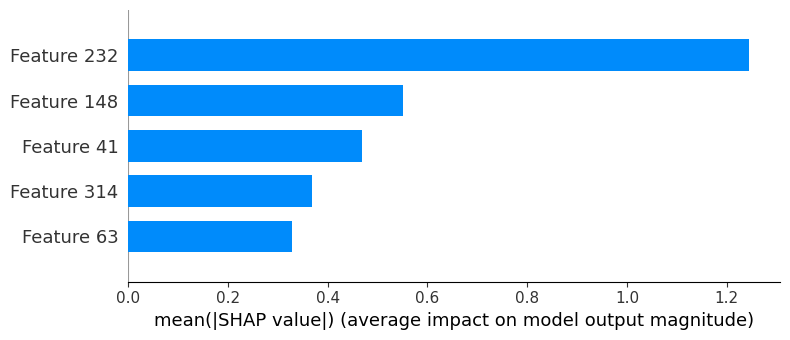

In [5]:
quantified_data = clf.interpret()
print("This should equals the height of the Feature 232-bar:", quantified_data.quantitative_data.obs['SHAP'][232])
print("This should equals the height of the Feature 148-bar:", quantified_data.quantitative_data.obs['SHAP'][148])
import shap

shap.summary_plot(clf.shap_values, clf.X, max_display=5, plot_type='bar')

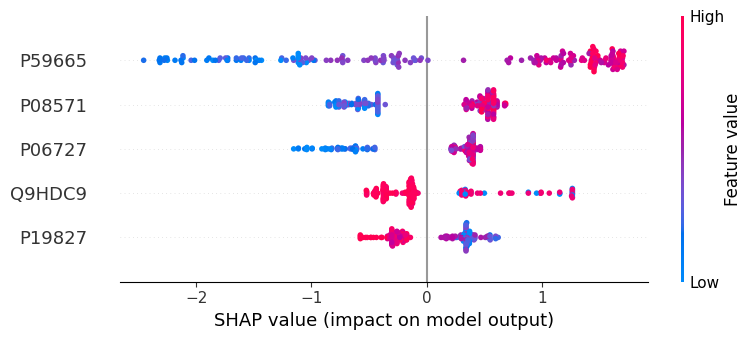

In [6]:
shap.summary_plot(clf.shap_values, clf.X, max_display=5, feature_names = quantified_data.quantitative_data.obs['Protein'])

In [7]:
clf.feature_importances_

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


array([0.01384006, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02855337, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01801231, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0476414 , 0.        , 0.        ,
       0.15187117, 0.        , 0.        , 0.        , 0.06997503,
       0.        , 0.4690526 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04378975, 0.02780835, 0.0191097 , 0.32817948, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [8]:
min_features_to_select = 10
step=10
rfe_results = clf.recursive_feature_elimination(min_features_to_select = min_features_to_select, step=step)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


ValueError: Feature shape mismatch, expected: 554, got 544

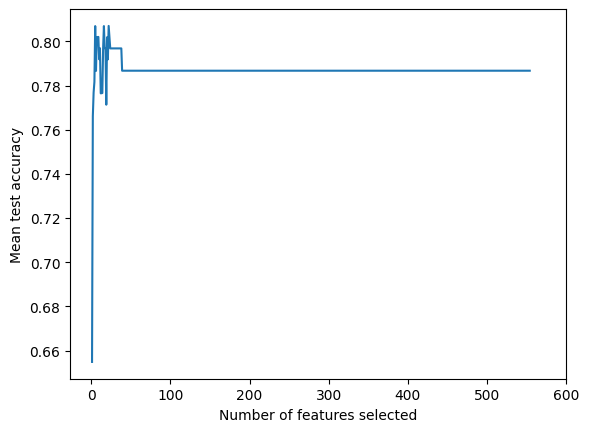

In [ ]:
import matplotlib.pyplot as plt

n_scores = len(rfe_results["mean_test_score"])

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.plot(
    range(min_features_to_select, n_scores+min_features_to_select),
    rfe_results["mean_test_score"],
    
)
plt.xticks(plt.xticks()[0][1:], 
           labels=[int(_)*step for _ in plt.xticks()[0][1:]])
plt.show()